In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from model import AutoEncoder_gnnrnn
from data import prepare_data_vocab, live_feat, batch_gnn_for_gpu, split_pp_into_sublists
import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
word_to_idx, idx_to_word, data, data_emb = prepare_data_vocab("data", func=live_feat, function_num=0)

In [10]:
bidir          = True
dir            = 2 if bidir else 1 
batch_size     = 64
num_layers_enc = 7
hidden_dim_enc = 15
num_layers_dec = 5
hidden_dim_dec = 13
emb_dim        = 33
N_max          = len(word_to_idx)+1

dataset = split_pp_into_sublists(data_emb, batch_size)

ae = AutoEncoder_gnnrnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            emb_dim        = emb_dim,
            N_max          = N_max)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

#device = torch.device("cpu")
ae.to(device)


data_gpu = batch_gnn_for_gpu(dataset, device)

criterion = nn.CrossEntropyLoss()
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)
epoch_num = 100
loss_list = []
for epoch in range(epoch_num):
    total_loss = 0
    total_items = 0
    j = -1
    for (padded_seq, padded_seq_dec, lengths, edge_index) in data_gpu:
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index)
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'For {j+1} functions: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss:.5f}', end='\r')
    loss_list.append(total_loss)

KeyboardInterrupt: 

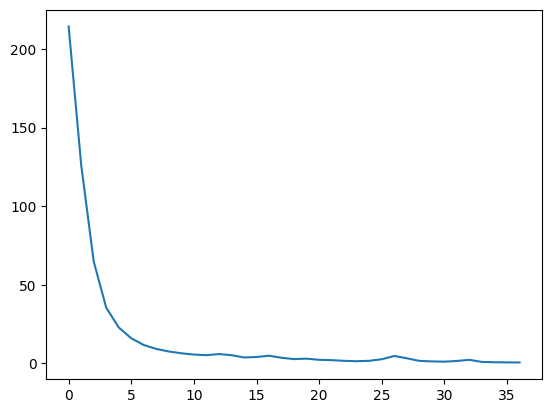

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

In [13]:
import torch

# Example tensor
tensor = torch.tensor([2, 3, 4, 5])

# Prepend a value
value_to_prepend = 1
tensor = torch.cat((torch.tensor([value_to_prepend]), tensor[:-1]), dim=0)

print(tensor)


tensor([1, 2, 3, 4])
